In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle

from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, precision_score



/Users/alpersaylam/Desktop/development/spam_detection-churn_analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocessing(text):
    """Changing text to lowercase ,removing extra spaces and cleaning the text.
    """
    text= text.lower().strip() 
    
    text=re.sub('[^a-zA-Z]',' ',text)
    
    text=re.sub(' +', ' ', text)
    return text

In [3]:
spam_data = pd.read_csv('./datasets/sms_spam_train.csv')
spam_data

,Message,Label
0,Whats upp ac enisteee: -) senin memlekette bul...,ham
1,"Kampanya, VakifBank Worldcardla 31 Mayisa kada...",spam
2,I wont. So wat's wit the guys,ham
3,Bu arada son dakika evi düşürdük,ham
4,No that just means you have a fat head,ham
...,...,...
9995,Degerli ogrencilerimiz egitim kariyerinize yur...,spam
9996,Oops. 4 got that bit.,ham
9997,"Kampanya: Money Dostu, bu oneri kacmaz! Money ...",spam
9998,"Süvari'de 2'li Fırsatlar,2 Takım+2 Gömlek+ 2 K...",spam


**Exploratory Data Analysis**


In [4]:
spam_data.isnull().sum()

Message    0
Label      0
dtype: int64

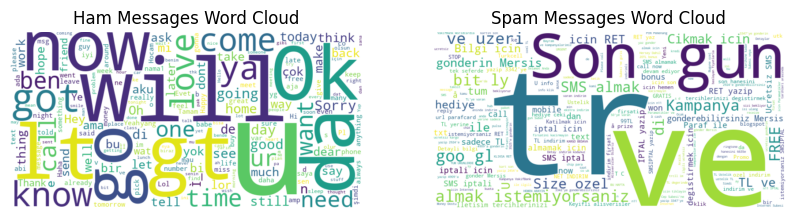

In [5]:
# Separate the data into ham and spam
ham_messages = " ".join(spam_data[spam_data['Label'] == 'ham']['Message'])
spam_messages = " ".join(spam_data[spam_data['Label'] == 'spam']['Message'])

# Generate word clouds
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_messages)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_messages)

# Plot the word clouds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.show()

<Axes: xlabel='Label', ylabel='count'>

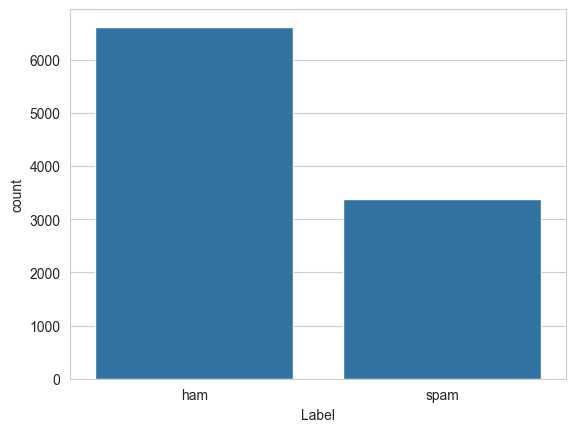

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Label',data=spam_data)

**Data Preprocessing**

In [7]:
LE=LabelEncoder()
LE.fit(spam_data["Label"])
spam_data["Label"]=LE.transform(spam_data["Label"])

In [8]:
spam_data['Message']=spam_data['Message'].apply(preprocessing)
spam_data.head()


,Message,Label
0,whats upp ac enisteee senin memlekette buldum,0
1,kampanya vakifbank worldcardla mayisa kadar wo...,1
2,i wont so wat s wit the guys,0
3,bu arada son dakika evi d rd k,0
4,no that just means you have a fat head,0


In [9]:
'''We can use the following encodersfor the text data:
    paraphrase-multilingual-MiniLM-L12-v2,  paraphrase-multilingual-mpnet-base-v2, distiluse-base-multilingual-cased'''
Encoder = SentenceTransformer('distiluse-base-multilingual-cased')
embeddings=Encoder.encode(spam_data["Message"]) # Encode text into vectors 


**Split data for models**


In [10]:
x = embeddings
y = spam_data["Label"]
X_train,X_test,y_train,y_test= train_test_split(x,y,test_size=0.20,random_state=42)


**Train and Evaluate Models**


SVC - Confusion Matrix:


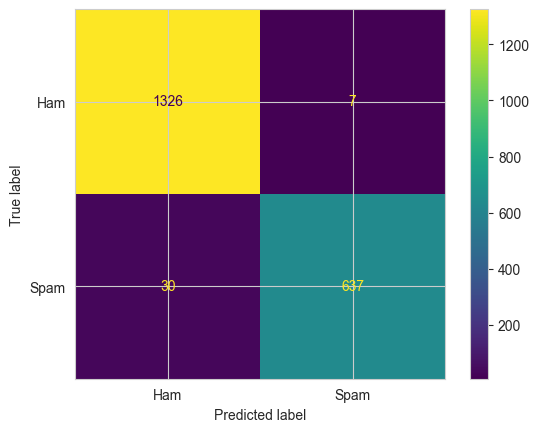


Logistic Regression - Confusion Matrix:


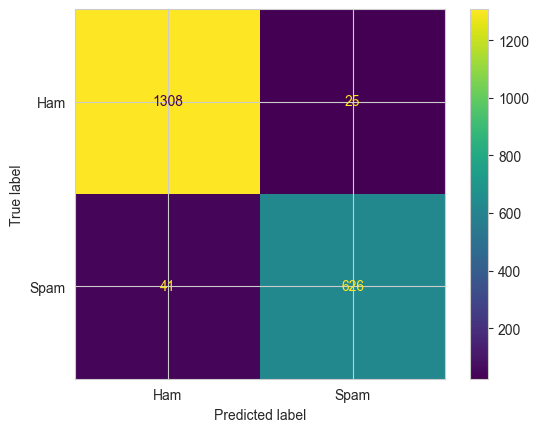


Random Forest - Confusion Matrix:


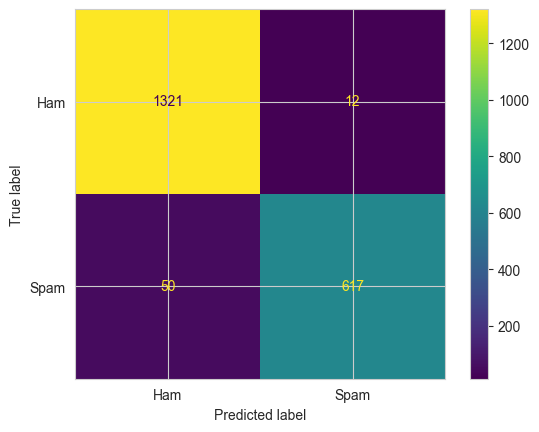

                 Model  F1 Score    Recall  Precision  \
0                  SVC  0.971777  0.955022   0.989130   
2        Random Forest  0.952160  0.925037   0.980922   
1  Logistic Regression  0.949924  0.938531   0.961598   

                                       trained_model  
0                                              SVC()  
2  (DecisionTreeClassifier(max_features='sqrt', r...  
1                               LogisticRegression()  


In [11]:
# Define models
models = {
    "SVC": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}

# Store results
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    f1_test = f1_score(y_test, y_test_pred, average='binary')
    recall_test_score = recall_score(y_test, y_test_pred, average='binary')
    precision_test_score = precision_score(y_test, y_test_pred, average='binary')
    
    results.append({
        "Model": model_name,
        "F1 Score": f1_test,
        "Recall": recall_test_score,
        "Precision": precision_test_score,
        "trained_model": model
    })
    
    print(f"\n{model_name} - Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Ham", "Spam"])
    cm_display.plot()
    plt.show()
# Display results
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(results_df)

***Save the model***

In [12]:
import pickle

model = results_df.loc[results_df.index[0], "trained_model"]
with open('model_spam_detection.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model for spam detection saved as model.pkl")

Model for spam detection saved as model.pkl
